### Importando bibliotecas necessárias

In [59]:
import pandas as pd
import csv

from graph_tool import Graph
import os
from graph_tool import util
import netpixi
import pickle

from regression.integration.gt import *
from netpixi.integration.gt import *

### Dataset NBA players

In [60]:
import pandas as pd
df=pd.read_csv("all_seasons.csv")
df_new=df[['player_name','team_abbreviation','season']]
df_new

,player_name,team_abbreviation,season
0,Dennis Rodman,CHI,1996-97
1,Dwayne Schintzius,LAC,1996-97
2,Earl Cureton,TOR,1996-97
3,Ed O'Bannon,DAL,1996-97
4,Ed Pinckney,MIA,1996-97
...,...,...,...
12300,Markieff Morris,MIA,2021-22
12301,Markelle Fultz,ORL,2021-22
12302,Marcus Smart,BOS,2021-22
12303,Marcus Garrett,MIA,2021-22


### Criação do grafo

In [61]:
from netpixi.integration.gt import Graph

g = Graph(directed=False) # não dirigido

In [62]:
# lista de jogadores
players = df_new['player_name'].unique().tolist()

In [63]:
# adicionar nós para cada jogador
for player in players:
    g.add_vertex(player)

In [64]:
N=3
# filtra os jogadores que jogaram juntos por mais de 3 temporadas
df_filtered = df_new.groupby(['team_abbreviation', 'player_name']).filter(lambda x: x['season'].nunique() > N)

# adiciona as arestas ao grafo
for _, group in df_filtered.groupby(['team_abbreviation', 'season']):
    players = group['player_name'].tolist()
    for i in range(len(players)):
        for j in range(i+1, len(players)):
            # verifica se os jogadores jogaram juntos por mais de 3 temporadas
            num_seasons = len(set(df_new[(df_new['player_name']==players[i]) & (df_new['team_abbreviation']==group['team_abbreviation'].iloc[0])]['season']).intersection(
                                set(df_new[(df_new['player_name']==players[j]) & (df_new['team_abbreviation']==group['team_abbreviation'].iloc[0])]['season'])))
            if num_seasons > N:
                # verifica se a aresta não existe no grafo
                if not g.has_edge(players[i], players[j]):
                    # adiciona a aresta ao grafo
                    g.add_edge(players[i], players[j])


In [65]:
# # filtra os jogadores que jogaram juntos em uma temporada
# df_filtered = df_new.groupby(['team_abbreviation', 'season']).filter(lambda x: len(x) > 1)

# # adiciona as arestas ao grafo
# for _, group in df_filtered.groupby(['team_abbreviation', 'season']):
#     players = group['player_name'].tolist()
#     for i in range(len(players)):
#         for j in range(i+1, len(players)):
#             # verifica se a aresta já existe no grafo
#             if not g.has_edge(players[i], players[j]):
#                 # adiciona a aresta ao grafo
#                 g.add_edge(players[i], players[j])
                

### Análise Exploratória

#### a) Numero de vertices,arestas,densidade

In [66]:
#número de vértices
n = g.num_vertices()
print('O número de vértices é {0}'.format(n))

O número de vértices é 2463


In [67]:
#número de arestas
m = g.num_edges()
print('O número de arestas é {0}'.format(m))

O número de arestas é 1411


In [68]:
##densidade
max_edges = n * (n - 1)
d = m / max_edges
print('A densidade é {0}'.format(round(d,4)))

A densidade é 0.0002


In [69]:
data_targets = pd.DataFrame({k: list(v) for k, v in g.vp.items()})
data_targets.head()

,id
0,Dennis Rodman
1,Dwayne Schintzius
2,Earl Cureton
3,Ed O'Bannon
4,Ed Pinckney


#### B) Estatísticas e histograma do degree. (não é necessário in-degree e out-degree)

In [70]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())

data_targets['degree'] = degrees
data_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2463 non-null   object
 1   degree  2463 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.6+ KB


count    2463.000000
mean        1.145757
std         2.546614
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        23.000000
Name: degree, dtype: float64

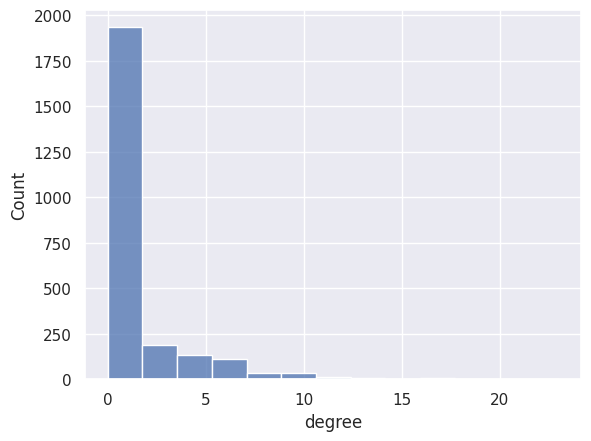

In [71]:
import seaborn as sns
sns.histplot(data_targets['degree'])
data_targets['degree'].describe()

### Análise Visual do Grafo

#### A) Salvando o arquivo

In [54]:
gt_save(g,'Nba_teams.gz')
g = gt_clean(g)

#### B) Visualizando o grafo

In [55]:
g = gt_load('Nba_teams.gz')
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
r=netpixi.render('Nba_teams.gz',infinite=True);

#### C) Ajustando as propriedades visuais do grafo

In [56]:
# mudar a cor de fundo do grafo
r.graph(color=0xdddddd)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0xcccccc, size=10)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0x000000, width=1, curve1=2, curve2=2)

### Regressão linear

In [72]:
df_regression=df[['player_name','team_abbreviation','draft_year','draft_number','net_rating','season']]
df_regression

,player_name,team_abbreviation,draft_year,draft_number,net_rating,season
0,Dennis Rodman,CHI,1986,27,16.1,1996-97
1,Dwayne Schintzius,LAC,1990,24,12.3,1996-97
2,Earl Cureton,TOR,1979,58,-2.1,1996-97
3,Ed O'Bannon,DAL,1995,9,-8.7,1996-97
4,Ed Pinckney,MIA,1985,10,-11.2,1996-97
...,...,...,...,...,...,...
12300,Markieff Morris,MIA,2011,13,4.5,2021-22
12301,Markelle Fultz,ORL,2017,1,-5.3,2021-22
12302,Marcus Smart,BOS,2014,6,9.3,2021-22
12303,Marcus Garrett,MIA,Undrafted,Undrafted,5.8,2021-22


### Clustering Coefficient

In [73]:
#calculando clustering coefficient:
from graph_tool import clustering

lc = clustering.local_clustering(g)

for value in lc:
    print(value)
    

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.3333333333333333
1.0
0.39285714285714285
1.0
0.6
0.0
1.0
0.0
0.0
0.0
0.0
0.5272727272727272
0.0
0.0
0.0
1.0
0.9047619047619048
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.5
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.9047619047619048
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.21428571428571427
0.0
0.0
0.0
1.0
0.0
0.42424242424242425
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4666666666666667
1.0
0.0
0.0
0.23809523809523808
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.3333333333333333
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.6666666666666666
0.0
0.0
0.0
0.0
0.0
1.0
0.6666666666666666
0.0
0.8095238095238095
0.0
0.0
0.6
1.0
0.0
1.0
0.0
0.5
0.0
0.4642857142857143
0.26666666666666666
0.36363636363636365
0.0
0.0
0.6666666666666666
0.0
1.0
0.0
0.0
0.0
0.5714285714285714
0.0
0.5714285714285714
1.0
0.0
0.0
0.8095238095238095
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

In [74]:
g.add_vp('clustering', lc)

In [75]:
clustering=gt_data(g)['clustering']


In [76]:
df_regression['adaptabilidade']=clustering
df_regression

/tmp/ipykernel_14/3890896009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression['adaptabilidade']=clustering


,player_name,team_abbreviation,draft_year,draft_number,net_rating,season,adaptabilidade
0,Dennis Rodman,CHI,1986,27,16.1,1996-97,NaN
1,Dwayne Schintzius,LAC,1990,24,12.3,1996-97,NaN
2,Earl Cureton,TOR,1979,58,-2.1,1996-97,NaN
3,Ed O'Bannon,DAL,1995,9,-8.7,1996-97,NaN
4,Ed Pinckney,MIA,1985,10,-11.2,1996-97,NaN
...,...,...,...,...,...,...,...
12300,Markieff Morris,MIA,2011,13,4.5,2021-22,NaN
12301,Markelle Fultz,ORL,2017,1,-5.3,2021-22,NaN
12302,Marcus Smart,BOS,2014,6,9.3,2021-22,NaN
12303,Marcus Garrett,MIA,Undrafted,Undrafted,5.8,2021-22,NaN


### Regressão Linear

In [77]:
df_regression["draft_number"] = df_regression["draft_number"].replace("Undrafted", 0).astype(int)
df_regression["draft_year"] = df_regression["draft_year"].replace("Undrafted", 0).astype(int)
df_regression


/tmp/ipykernel_14/2373059091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression["draft_number"] = df_regression["draft_number"].replace("Undrafted", 0).astype(int)
/tmp/ipykernel_14/2373059091.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression["draft_year"] = df_regression["draft_year"].replace("Undrafted", 0).astype(int)


,player_name,team_abbreviation,draft_year,draft_number,net_rating,season,adaptabilidade
0,Dennis Rodman,CHI,1986,27,16.1,1996-97,NaN
1,Dwayne Schintzius,LAC,1990,24,12.3,1996-97,NaN
2,Earl Cureton,TOR,1979,58,-2.1,1996-97,NaN
3,Ed O'Bannon,DAL,1995,9,-8.7,1996-97,NaN
4,Ed Pinckney,MIA,1985,10,-11.2,1996-97,NaN
...,...,...,...,...,...,...,...
12300,Markieff Morris,MIA,2011,13,4.5,2021-22,NaN
12301,Markelle Fultz,ORL,2017,1,-5.3,2021-22,NaN
12302,Marcus Smart,BOS,2014,6,9.3,2021-22,NaN
12303,Marcus Garrett,MIA,0,0,5.8,2021-22,NaN


In [84]:
# Separa a coluna "season" em duas colunas, "start_year" e "end_year", contendo o ano inicial e o ano final da temporada, respectivamente
df_regression[["start_year", "end_year"]] = df_regression["season"].str.split("-", expand=True)

# Converte as colunas "start_year" e "end_year" em inteiros
df_regression[["start_year", "end_year"]] = df_regression[["start_year", "end_year"]].astype(int)

# Calcula o número de anos jogados na NBA como a diferença entre o ano final da temporada e o ano de draft
df_regression["years_played"] = df_regression["end_year"] - df_regression["draft_year"]
df_regression['years_played']=df_regression["draft_year"].replace("Undrafted", 0)
df_regression




/tmp/ipykernel_14/4024472371.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression[["start_year", "end_year"]] = df_regression["season"].str.split("-", expand=True)
/tmp/ipykernel_14/4024472371.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression[["start_year", "end_year"]] = df_regression["season"].str.split("-", expand=True)
/tmp/ipykernel_14/4024472371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,player_name,team_abbreviation,draft_year,draft_number,net_rating,season,adaptabilidade,years_played,start_year,end_year
0,Dennis Rodman,CHI,1986,27,16.1,1996-97,NaN,1986,1996,97
1,Dwayne Schintzius,LAC,1990,24,12.3,1996-97,NaN,1990,1996,97
2,Earl Cureton,TOR,1979,58,-2.1,1996-97,NaN,1979,1996,97
3,Ed O'Bannon,DAL,1995,9,-8.7,1996-97,NaN,1995,1996,97
4,Ed Pinckney,MIA,1985,10,-11.2,1996-97,NaN,1985,1996,97
...,...,...,...,...,...,...,...,...,...,...
12300,Markieff Morris,MIA,2011,13,4.5,2021-22,NaN,2011,2021,22
12301,Markelle Fultz,ORL,2017,1,-5.3,2021-22,NaN,2017,2021,22
12302,Marcus Smart,BOS,2014,6,9.3,2021-22,NaN,2014,2021,22
12303,Marcus Garrett,MIA,0,0,5.8,2021-22,NaN,0,2021,22


In [81]:
import regression as reg

from scipy import stats

result=reg.linear(data=df_regression,formula='years_played ~ draft_number+net_rating ')


In [82]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           years_played   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     2104.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        21:55:45   Log-Likelihood:                -97450.
No. Observations:               12305   AIC:                         1.949e+05
Df Residuals:                   12302   BIC:                         1.949e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1243.2491      8.787    141.484      0.000    1226.025    1260.473
draft_number    22.9673      0.357     64.321      0.000      22.267      23.667
net_rating       4.8866      0.474     10.316      0.000       3.958       5.815
==============================================================================
Omnibus:                     1379.823   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1849.038
Skew:                          -0.939   Prob(JB):                         0.00
Kurtosis:                       2.719   Cond. No.                         36.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
result.micro_summary()

variable,coefficient,std error,p-value
draft_number,22.967307,0.357073,0.000000
net_rating,4.886615,0.473684,0.000000
